Normal samples: Total 7426, After filtering 7419
Backwards samples: Total 6207, After filtering 5237
Forwards samples: Total 6231, After filtering 6133


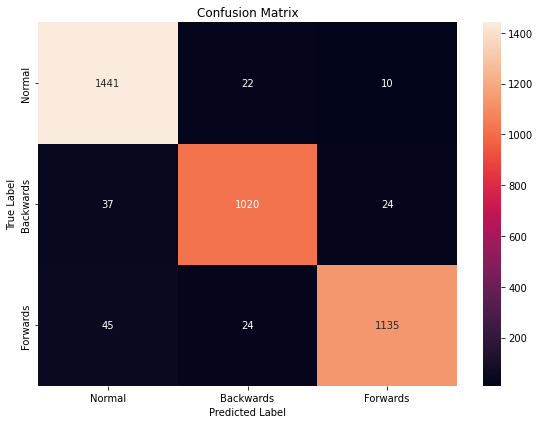

              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96      1473
   Backwards       0.96      0.94      0.95      1081
    Forwards       0.97      0.94      0.96      1204

    accuracy                           0.96      3758
   macro avg       0.96      0.95      0.96      3758
weighted avg       0.96      0.96      0.96      3758



In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class PostureFeatureExtractor:
    def extract_features(self, keypoints):
        """
        Extract features from 3D keypoints, adding a vertical nose offset feature
        to help distinguish backward vs. normal posture.
        
        Args:
            keypoints (np.array): shape (17, 3), each row is (x, y, z)
        
        Returns:
            np.array: Extracted features (including vertical_nose_offset)
        """
        # Indices (assuming COCO-style or similar)
        nose = keypoints[0]            # (x, y, z)
        left_shoulder = keypoints[11]  # (x, y, z)
        right_shoulder = keypoints[12] # (x, y, z)
        
        # 1. Shoulder line & length
        shoulder_vector = right_shoulder - left_shoulder
        shoulder_length = np.linalg.norm(shoulder_vector)
        
        # Horizontal angle (projection onto the XY plane)
        horizontal_angle = np.arctan2(shoulder_vector[1], shoulder_vector[0])

        # Vertical angle (projection onto the XZ plane)
        vertical_angle = np.arctan2(
            shoulder_vector[2],
            np.sqrt(shoulder_vector[0]**2 + shoulder_vector[1]**2)
        )

        # Depth angle (projection onto the YZ plane)
        depth_angle = np.arctan2(
            shoulder_vector[2],
            np.sqrt(shoulder_vector[0]**2 + shoulder_vector[1]**2 + shoulder_vector[2]**2)
        )
        
        # 3. Nose deviation from shoulder line (existing feature)
        if shoulder_length != 0:
            shoulder_unit_vector = shoulder_vector / shoulder_length
        else:
            shoulder_unit_vector = np.array([0, 0, 0])  # degenerate case
        
        nose_projection = np.dot(nose - left_shoulder, shoulder_unit_vector)
        nose_deviation = np.linalg.norm((nose - left_shoulder) - nose_projection * shoulder_unit_vector)
        
        # 4. Z offset (if you already have it)
        mid_shoulder = (left_shoulder + right_shoulder) / 2.0
        z_offset = nose[2] - mid_shoulder[2]  # forward/back offset
        
        # 5. **NEW** vertical offset (assuming y is vertical)
        
        # Existing distance calculation
        nose_distance = np.linalg.norm(nose - mid_shoulder)
        
        nose_angle = calculate_angle_nose_shoulder_yaxis(nose, left_shoulder, right_shoulder)

#         # Calculate shoulder width to use as a normalizing factor
#         shoulder_width = np.linalg.norm(left_shoulder - right_shoulder)

#         # Normalized nose distance
#         normalized_nose_distance = nose_distance / shoulder_width if shoulder_width != 0 else 0
        
        # Combine into a bigger feature vector
        features = np.array([
            shoulder_length,
            horizontal_angle,
            vertical_angle,
            depth_angle,
            nose_deviation,
            z_offset,             # existing feature for forward/back separation
            nose_distance,  # new feature for backward/normal separation
            nose_angle
        ])
        
        return features
    

def calculate_angle_nose_shoulder_yaxis(nose_vector, left_shoulder, right_shoulder):
    """
    Calculate the angle between the nose position and the shoulder midpoint relative to the y-axis.

    Parameters:
        nose_vector (numpy array): A vector [x, y, z] representing the nose position.
        left_shoulder (numpy array): A vector [x, y, z] representing the left shoulder position.
        right_shoulder (numpy array): A vector [x, y, z] representing the right shoulder position.

    Returns:
        float: The angle in radians between the nose and the shoulder midpoint relative to the y-axis.
    """
    # Calculate the midpoint of the shoulders
    shoulder_midpoint = (left_shoulder + right_shoulder) / 2.0

    # Calculate the vector difference between the nose and shoulder midpoint
    vector_diff = nose_vector - shoulder_midpoint

    # Define the y-axis vector
    y_axis_vector = np.array([0, 1, 0])

    # Calculate the magnitudes of the vectors
    mag_vector_diff = np.linalg.norm(vector_diff)
    mag_y_axis = np.linalg.norm(y_axis_vector)

    # Prevent division by zero
    if mag_vector_diff == 0:
        raise ValueError("Vector difference is zero, cannot compute angle.")

    # Calculate the dot product
    dot_product = np.dot(vector_diff, y_axis_vector)

    # Calculate the angle (in radians)
    angle = np.arccos(dot_product / (mag_vector_diff * mag_y_axis))

    return angle

def prepare_dataset(results_normal, results_backwards, results_forwards):
    """
    Prepare dataset from different posture types
    Ignore samples where nose is NaN
    
    Args:
        results_normal (np.array): Good posture keypoints
        results_backwards (np.array): Bad posture - backwards
        results_forwards (np.array): Bad posture - forwards
    
    Returns:
        tuple: X (features), y (labels)
    """
    extractor = PostureFeatureExtractor()
    
    # Filter out samples where nose is NaN
    normal_valid_indices = ~np.isnan(results_normal[:, 0]).any(axis=1)
    backwards_valid_indices = ~np.isnan(results_backwards[:, 0]).any(axis=1)
    forwards_valid_indices = ~np.isnan(results_forwards[:, 0]).any(axis=1)
    
    # Filter datasets
    results_normal_filtered = results_normal[normal_valid_indices]
    results_backwards_filtered = results_backwards[backwards_valid_indices]
    results_forwards_filtered = results_forwards[forwards_valid_indices]
    
    # Print filtering information
    print(f"Normal samples: Total {len(results_normal)}, After filtering {len(results_normal_filtered)}")
    print(f"Backwards samples: Total {len(results_backwards)}, After filtering {len(results_backwards_filtered)}")
    print(f"Forwards samples: Total {len(results_forwards)}, After filtering {len(results_forwards_filtered)}")
    
    # Extract features for filtered datasets
    X_normal = np.array([extractor.extract_features(sample) for sample in results_normal_filtered])
    X_backwards = np.array([extractor.extract_features(sample) for sample in results_backwards_filtered])
    X_forwards = np.array([extractor.extract_features(sample) for sample in results_forwards_filtered])
    
    # Create labels
    y_normal = np.zeros(len(X_normal))  # 0 for normal posture
    y_backwards = np.ones(len(X_backwards))  # 1 for backwards posture
    y_forwards = np.full(len(X_forwards), 2)  # 2 for forwards posture
    
    # Combine datasets
    X = np.vstack((X_normal, X_backwards, X_forwards))
    y = np.concatenate((y_normal, y_backwards, y_forwards))
    
    return X, y



def train_and_evaluate_model(X, y):
    """
    Train and evaluate classification model
    
    Args:
        X (np.array): Features
        y (np.array): Labels
    
    Returns:
        tuple: Trained model, classification report
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM Classifier
    classifier = SVC(kernel='rbf', random_state=42)
    classifier.fit(X_train_scaled, y_train)
    joblib.dump(classifier, '../model_checkpoint/svm_latest.joblib')


    
    # Predict and evaluate
    y_pred = classifier.predict(X_test_scaled)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, 
                                   target_names=['Normal', 'Backwards', 'Forwards'])
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['Normal', 'Backwards', 'Forwards'],
                yticklabels=['Normal', 'Backwards', 'Forwards'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return classifier, report

# Example usage
def main():
    # Load keypoints data
    results_normal = np.load('../keypoints/normal_keypoints/keypoints_img_coord.npy')
    results_backwards = np.load('../keypoints/backward_keypoints/keypoints_img_coord.npy')
    results_forwards = np.load('../keypoints/forward_keypoints/keypoints_img_coord.npy')
    
    # Prepare dataset
    X, y = prepare_dataset(results_normal, results_backwards, results_forwards)
    
    # Train and evaluate
    classifier, report = train_and_evaluate_model(X, y)
    
    # Print classification report
    print(report)

if __name__ == '__main__':
    main()

Normal samples: Total 7426, After filtering 7419
Backwards samples: Total 5820, After filtering 4911
Forwards samples: Total 5460, After filtering 5372


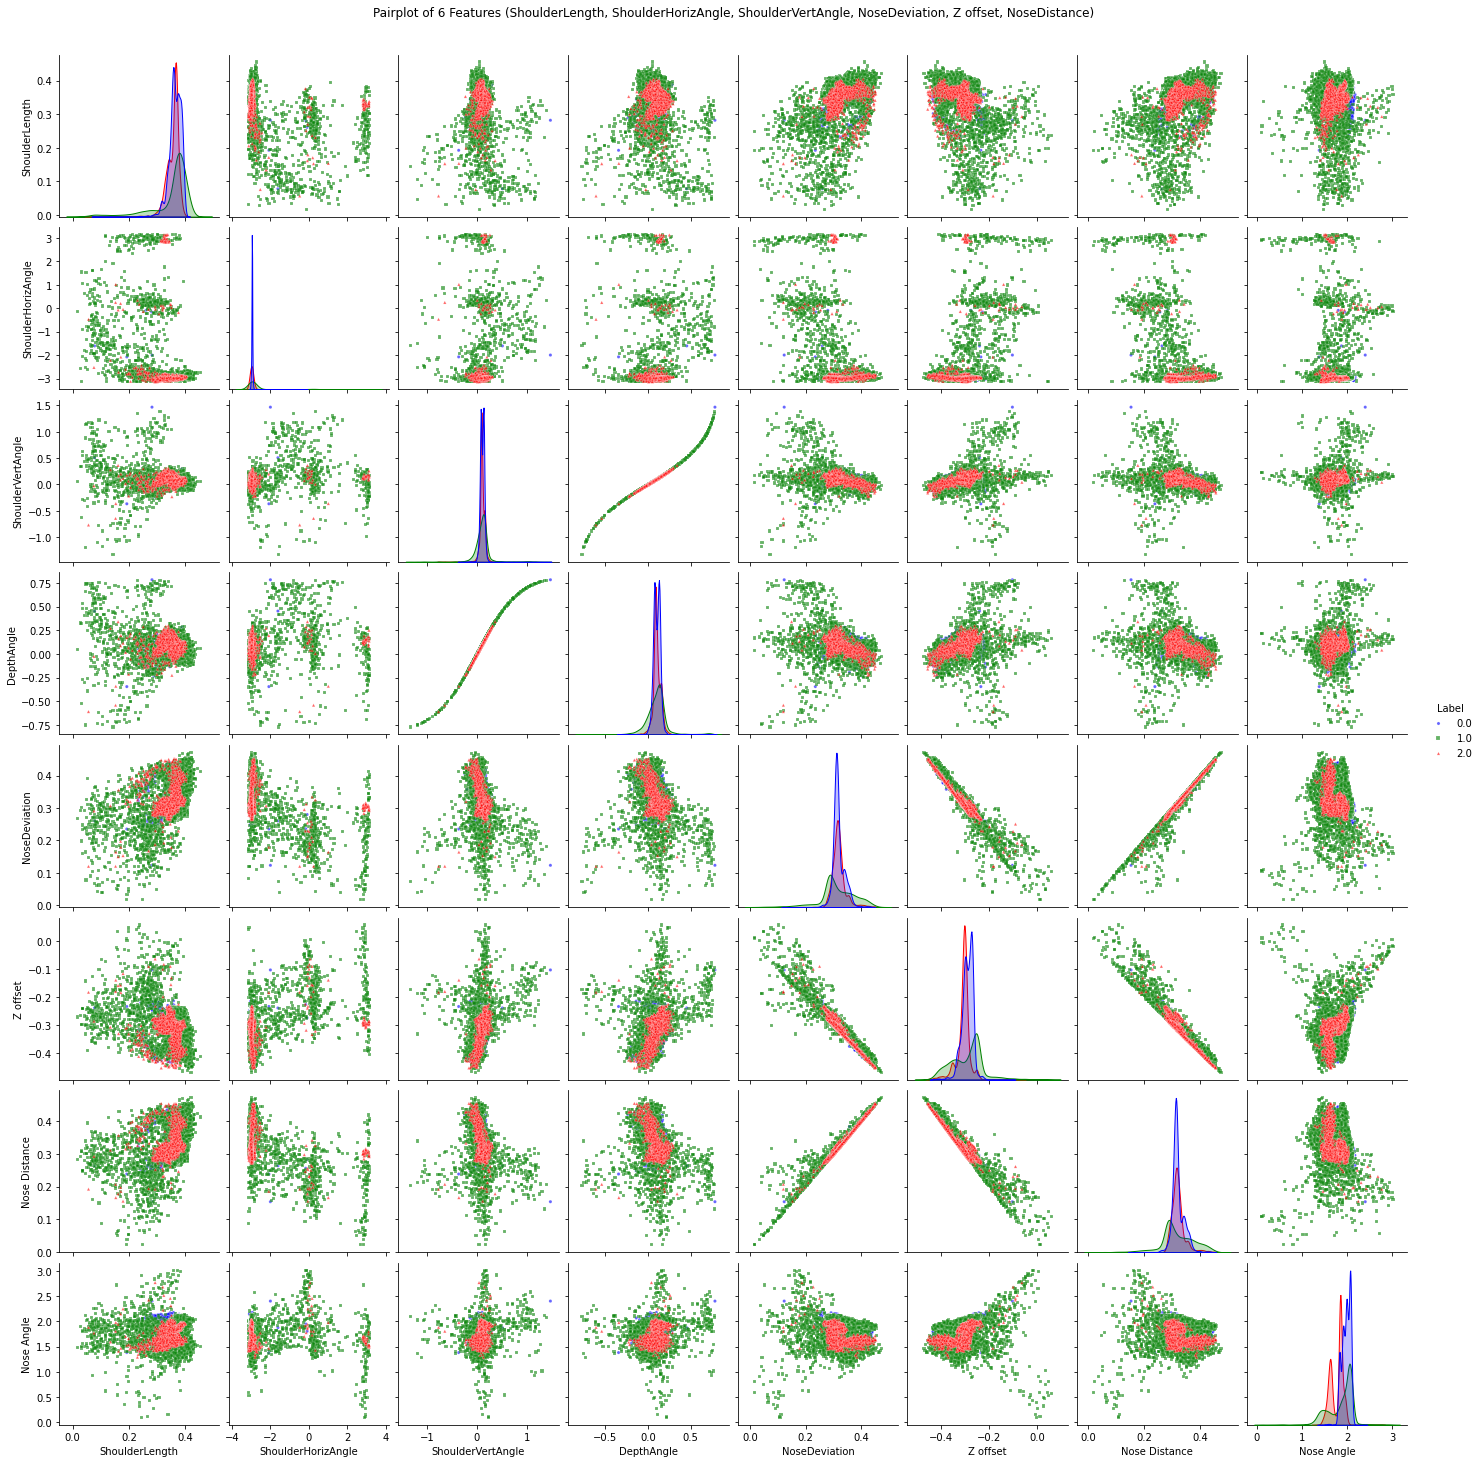

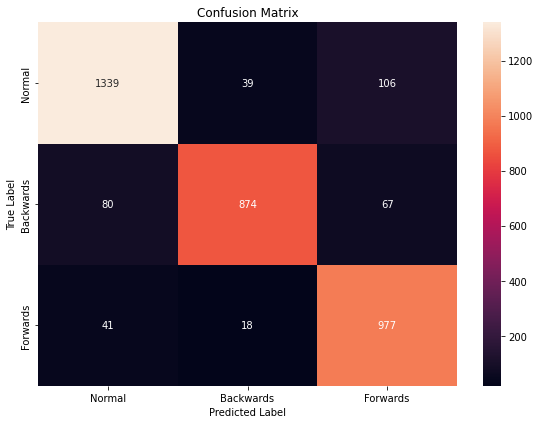

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_features_pairplot(X, y):
    """
    Create a pairplot of the 7 extracted features in X, colored by y.
    X: shape (n_samples, 7)
    y: shape (n_samples,)
    """
#     Convert X,y to a pandas DataFrame for easy plotting
    df = pd.DataFrame(X, columns=['ShoulderLength', 'ShoulderHorizAngle', 
                                  'ShoulderVertAngle', 'DepthAngle', 'NoseDeviation', 'Z offset', 'Nose Distance', 'Nose Angle'])
    df['Label'] = y  # add labels as a column
#     print(df)

    # Create a pairplot, color-coded by 'Label'
    sns.pairplot(
        df, 
        hue='Label',
        diag_kind='kde', 
        palette={0.0: 'blue', 1.0: 'green', 2.0: 'red'},
        markers=['o', 's', '^'],  # circle, square, triangle
        plot_kws={'alpha': 0.6, 's': 10}   # make points partially transparent
    )
#     g = sns.PairGrid(df, hue='Label', palette={0.0: 'blue', 1.0: 'green', 2.0: 'red'})
#     g.map_diag(sns.kdeplot)
#     g.map_offdiag(sns.scatterplot, alpha=0.6)
#     g.add_legend()
#     g.map_upper(lambda x, y, **kwargs: sns.scatterplot(x, y, **kwargs, s=30))
#     g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x, y, **kwargs, s=30))
    # Adjusting visibility per class in upper or lower triangle can be very revealing
    plt.suptitle("Pairplot of 6 Features (ShoulderLength, ShoulderHorizAngle, ShoulderVertAngle, NoseDeviation, Z offset, NoseDistance)",
                 y=1.02)  # shift title up a bit
    plt.show()

# # After you prepare your dataset (X, y):
X, y = prepare_dataset(results_normal, results_backwards, results_forwards)

plot_features_pairplot(X, y)

# Then proceed to train_and_evaluate_model(...)
classifier, report = train_and_evaluate_model(X, y)
# df = pd.DataFrame(X, columns=['ShoulderLength', 'ShoulderHorizAngle', \
#                               'ShoulderVertAngle', 'NoseDeviation', 'Z offset', 'Nose Distance'])

# df['Label'] = y  # add labels as a column

In [79]:
X.shape

(17702, 8)

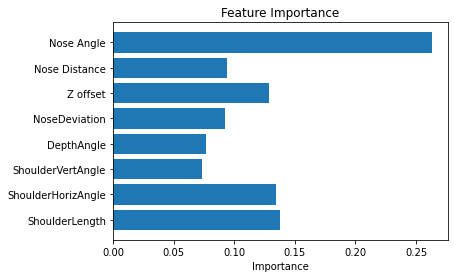

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = ['ShoulderLength', 'ShoulderHorizAngle', 
                                  'ShoulderVertAngle', 'DepthAngle', 'NoseDeviation', 'Z offset', 'Nose Distance', 'Nose Angle']
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

Normal samples: Total 7426, After filtering 7419
Backwards samples: Total 5820, After filtering 4911
Forwards samples: Total 5460, After filtering 5372


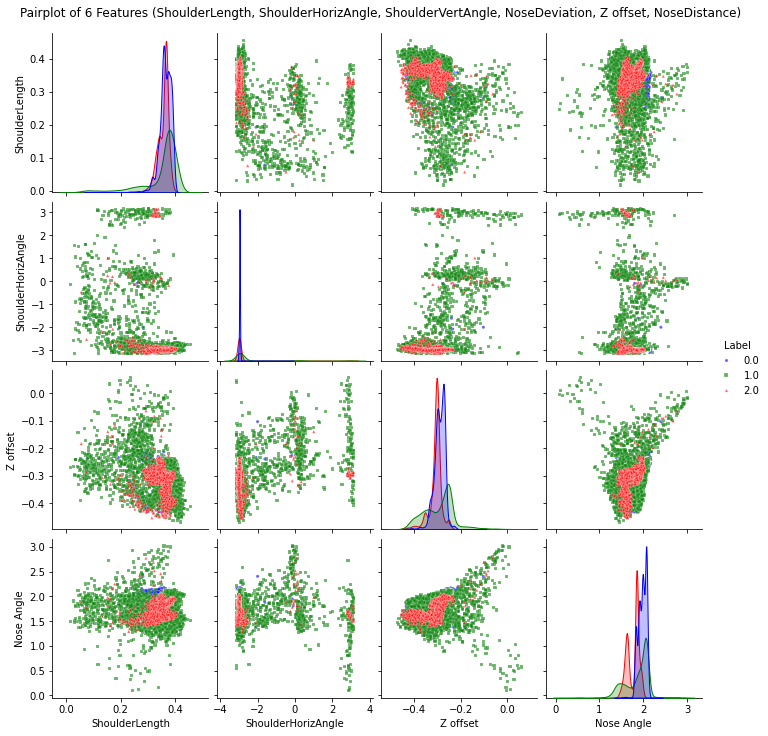

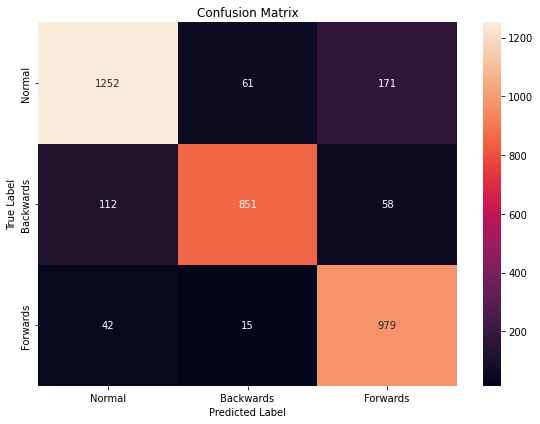

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_features_pairplot(X, y):
    """
    Create a pairplot of the 7 extracted features in X, colored by y.
    X: shape (n_samples, 7)
    y: shape (n_samples,)
    """
#     Convert X,y to a pandas DataFrame for easy plotting
    df = pd.DataFrame(X, columns=['ShoulderLength', 'ShoulderHorizAngle', 
                                   'Z offset', 'Nose Angle'])
    df['Label'] = y  # add labels as a column
#     print(df)

    # Create a pairplot, color-coded by 'Label'
    sns.pairplot(
        df, 
        hue='Label',
        diag_kind='kde', 
        palette={0.0: 'blue', 1.0: 'green', 2.0: 'red'},
        markers=['o', 's', '^'],  # circle, square, triangle
        plot_kws={'alpha': 0.6, 's': 10}   # make points partially transparent
    )
#     g = sns.PairGrid(df, hue='Label', palette={0.0: 'blue', 1.0: 'green', 2.0: 'red'})
#     g.map_diag(sns.kdeplot)
#     g.map_offdiag(sns.scatterplot, alpha=0.6)
#     g.add_legend()
#     g.map_upper(lambda x, y, **kwargs: sns.scatterplot(x, y, **kwargs, s=30))
#     g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x, y, **kwargs, s=30))
    # Adjusting visibility per class in upper or lower triangle can be very revealing
    plt.suptitle("Pairplot of 6 Features (ShoulderLength, ShoulderHorizAngle, ShoulderVertAngle, NoseDeviation, Z offset, NoseDistance)",
                 y=1.02)  # shift title up a bit
    plt.show()

# # After you prepare your dataset (X, y):
X, y = prepare_dataset(results_normal, results_backwards, results_forwards)

plot_features_pairplot(X, y)

# Then proceed to train_and_evaluate_model(...)
classifier, report = train_and_evaluate_model(X, y)
# df = pd.DataFrame(X, columns=['ShoulderLength', 'ShoulderHorizAngle', \
#                               'ShoulderVertAngle', 'NoseDeviation', 'Z offset', 'Nose Distance'])

# df['Label'] = y  # add labels as a column